In [1]:
train_folder = '../../mansegimages/train_coast/'
mask_folder = '../../mansegimages/mask_coast/'

In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras


from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import cv2 as cv2
import Augmentor
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,    
    RandomGamma    
)

In [3]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)


# config = tf.compat.v1.ConfigProto()
#config.gpu_options.allow_growth = True
# tf.compat.v1.enable_eager_execution(config=config)

In [4]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9146818859663046631
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1503836469437575873
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12189998088123431809
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5476122624
locality {
  bus_id: 1
  links {
  }
}
incarnation: 745243976088542275
physical_device_desc: "device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [7]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16563909980540128493
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7205791483406530597
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14728569872755148742
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5476122624
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5075245989462159165
physical_device_desc: "device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [8]:
tf.config.list_physical_devices()


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
# Set some parameters
im_width = 256
im_height = 256
border = 5
path_train =  '../../mansegimages/train_coast/'
mask_train =  '../../mansegimages/mask_coast/'

path_test = '../../mansegimages/test_coast/'
mask_test = '../../mansegimages/mask_test_coast/'

In [10]:
# p = Augmentor.Pipeline(path_train)
# Point to a directory containing ground truth data.
# Images with the same file names will be added as ground truth data
# and augmented in parallel to the original data.
# p.ground_truth(mask_train)
# Add operations to the pipeline as normal:
# p.rotate(probability=1, max_left_rotation=5, max_right_rotation=5)
# p.flip_left_right(probability=0.5)
# p.zoom_random(probability=1, percentage_area=0.5)
# p.flip_top_bottom(probability=0.5)
# p.sample(5000)

In [11]:
path_train = '../../mansegimages/train_coast/output/'

In [12]:
# Get and resize train images and masks
def get_data(path, maskp, train=True):
    ids = next(os.walk(path))[2]
    size = (int(len(ids)/2))
    print(size)
    X = np.zeros((size, im_height, im_width, 3), dtype=np.float32)
    if train:
        y = np.zeros((size, im_height, im_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')
    tmp = 0
    for n, id_ in enumerate(ids):
        # Load images
        if id_.startswith('train'):
            img = load_img(path  + id_, grayscale=False)
        
            x_img = img_to_array(img)
            x_img = resize(x_img, (im_height, im_width, 3), mode='constant', preserve_range=True)
        
            # Load masks
            if train:                
                
                id_ = id_.replace('train_coast_original_water', 'train_coast_water')
                
                mask_path = "{}_groundtruth_(1)_{}".format(path, id_)
                
                iml = load_img(mask_path, grayscale=True)
                mask = img_to_array(iml)
                mask = resize(mask, (im_height, im_width, 1), mode='constant', preserve_range=True)

            # Save images
            
            # X[n, ..., 0] = x_img.squeeze() / 255
            X[tmp] = x_img / 255
            if train:
                y[tmp] = mask / 255
            tmp += 1
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(path_train, mask_train, train=True)


5000
Getting and resizing images ... 


/home/angel/Desktop/git/beautyImages/jupyters/venv/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Done!


In [13]:
X.shape

(5000, 256, 256, 3)

In [14]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2018)

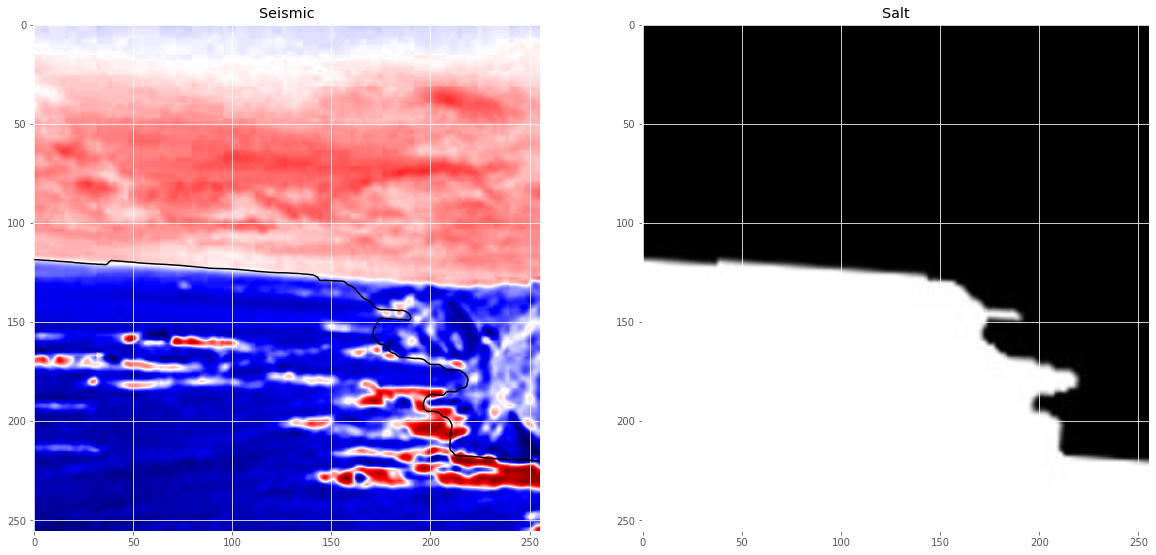

In [15]:
# Check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt');

In [16]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [17]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [18]:
input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [19]:
callbacks = [
    EarlyStopping(patience=20, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-sea.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [20]:
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# tf.compat.v1.enable_eager_execution(config=config)

# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.1
# sess = tf.compat.v1.Session(config=config)

In [22]:
results = model.fit(X_train, y_train, batch_size=16, epochs=100, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Train on 4250 samples, validate on 750 samples
Epoch 1/100
4240/4250 [============================>.] - ETA: 0s - loss: 0.5376 - accuracy: 0.6934
Epoch 00001: val_loss improved from inf to 0.85520, saving model to model-sea.h5
4250/4250 [==============================] - 58s 14ms/sample - loss: 0.5372 - accuracy: 0.6936 - val_loss: 0.8552 - val_accuracy: 0.7188
Epoch 2/100
4240/4250 [============================>.] - ETA: 0s - loss: 0.4096 - accuracy: 0.7843
Epoch 00002: val_loss improved from 0.85520 to 0.36512, saving model to model-sea.h5
4250/4250 [==============================] - 53s 13ms/sample - loss: 0.4096 - accuracy: 0.7843 - val_loss: 0.3651 - val_accuracy: 0.8291
Epoch 3/100
4240/4250 [============================>.] - ETA: 0s - loss: 0.3324 - accuracy: 0.8285
Epoch 00003: val_loss did not improve from 0.36512
4250/4250 [==============================] - 53s 13ms/sample - loss: 0.3323 - accuracy: 0.8285 - val_loss: 0.3706 - val_accuracy: 0.8257
Epoch 4/100
4240/4250 [=====

KeyboardInterrupt: 

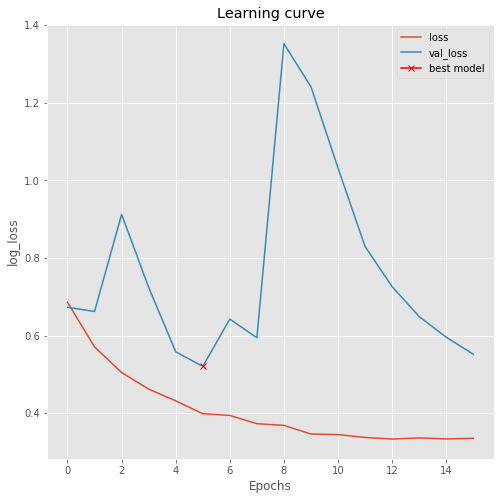

In [366]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [23]:
# Load best model
model.load_weights('model-sea.h5')

In [24]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

750/750 [==============================] - 3s 4ms/sample - loss: 0.0907 - accuracy: 0.9339


[0.09073018487294515, 0.93387866]

In [25]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

750/750 [==============================] - 3s 4ms/sample


In [26]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Origina')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask True')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted binary');

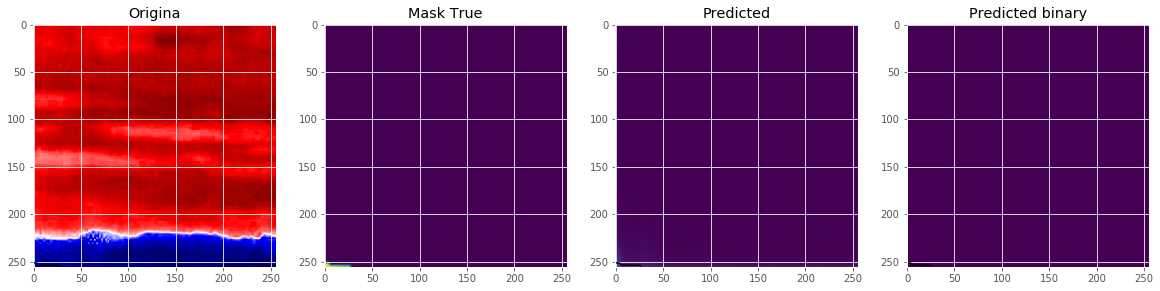

In [28]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=15)

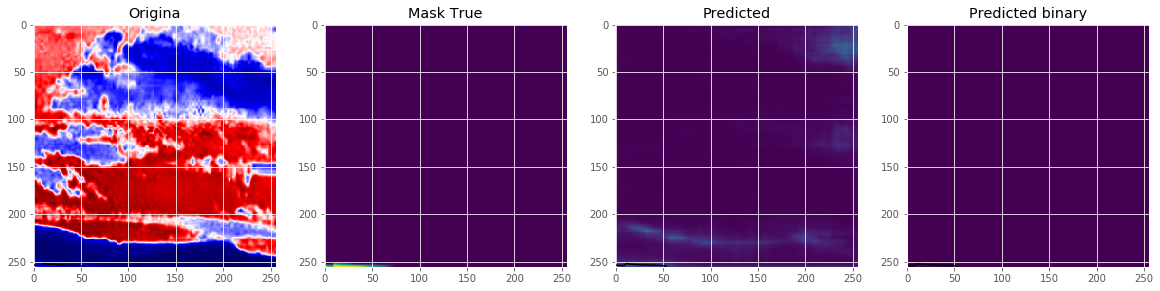

In [29]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=719)